# Hoja de trabajo 1
### Integrantes
 - Jose Santiago Pereira 22318
 - Nancy Gabriela Marariegos 22513
 - Brandon Reyes Morales 22992


## Task 1 - Análisis Teórico

Considere cada uno de los siguientes escenarios y responda según corresponda:

1. Como director de un proyecto de conducción autónoma, debe dimensionar el hardware para un nuevo vehículo. El sistema utiliza 8 cámaras que capturan video a resolución 4K UHD (3840 x 2160). Debido a la necesidad de alto rango dinámico (HDR), los sensores operan a 12 bits por píxel (Raw Bayer Pattern) a 60 FPS. **Métrica A: Enfocada puramente en el flujo vehicular.**
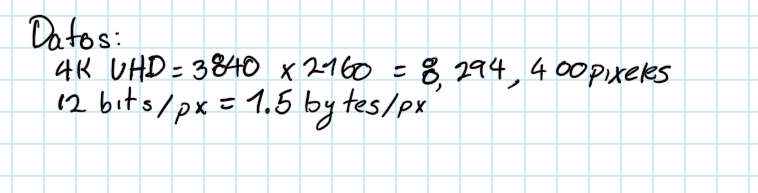
   a. Calcule el tamaño exacto de una sola imagen (frame) cruda en Megabytes (MB).  
   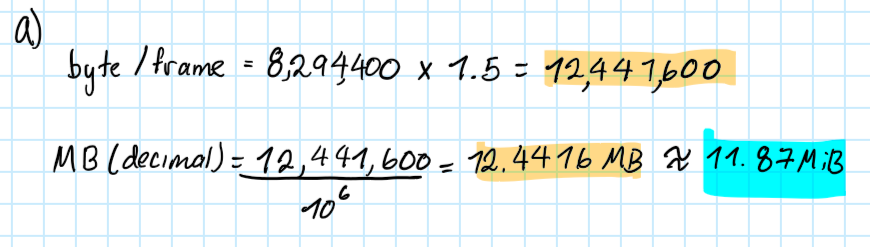


   b. Calcule el ancho de banda necesario (en Gbps) para transmitir el flujo de las 8 cámaras al procesador central sin compresión.  
   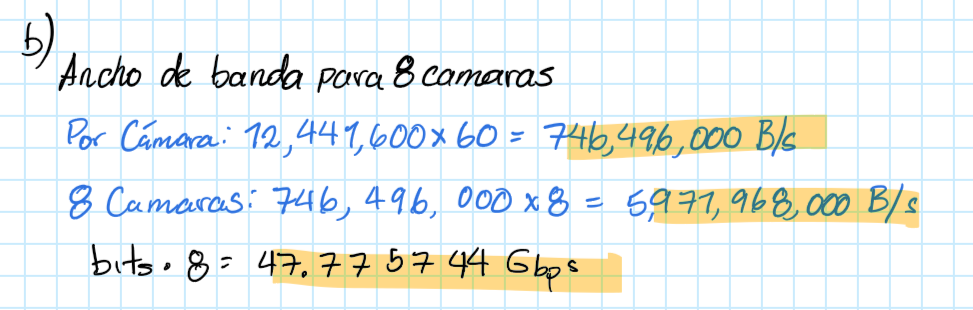


   c. Si su procesador tiene una memoria RAM reservada de 16 GB exclusivamente para el buffer de video, ¿cuántos segundos de historia puede almacenar antes de empezar a sobrescribir datos?  
   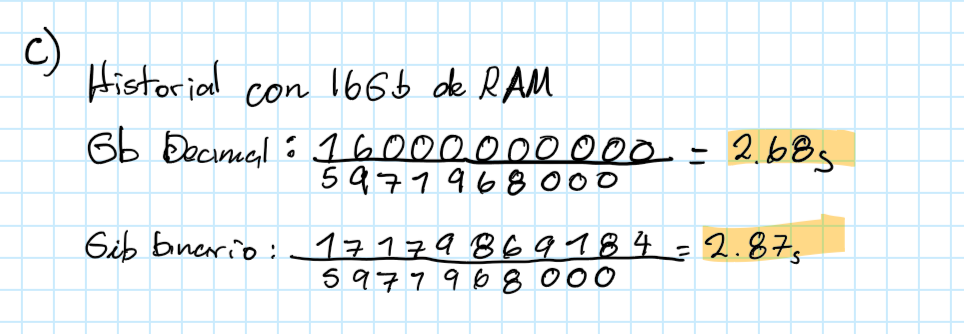


   d. Basado en su resultado, ¿es viable enviar estos datos "crudos" a la nube en tiempo real usando 5G? Justifique  

    - R//: En este caso no es sostenible Gbps de uplink, se necesita procesamiento en el borde de CPU/GPU y compresión.
   
2. Considere un píxel con valor de intensidad Iin=50 en una imagen estándar de 8 bits (0−255). Se aplican dos procesos de mejora secuenciales en el siguiente orden:

   I. Corrección Gamma con γ=0.5 (para expandir sombras).  
   II. Ajuste Lineal con ganancia α=1.2 y brillo β=-10 (para contrastar).  

   Realice los cálculos en el dominio de flotantes normalizados [0,1] como dicta la buena práctica y convierta a entero de 8 bits solo al final.

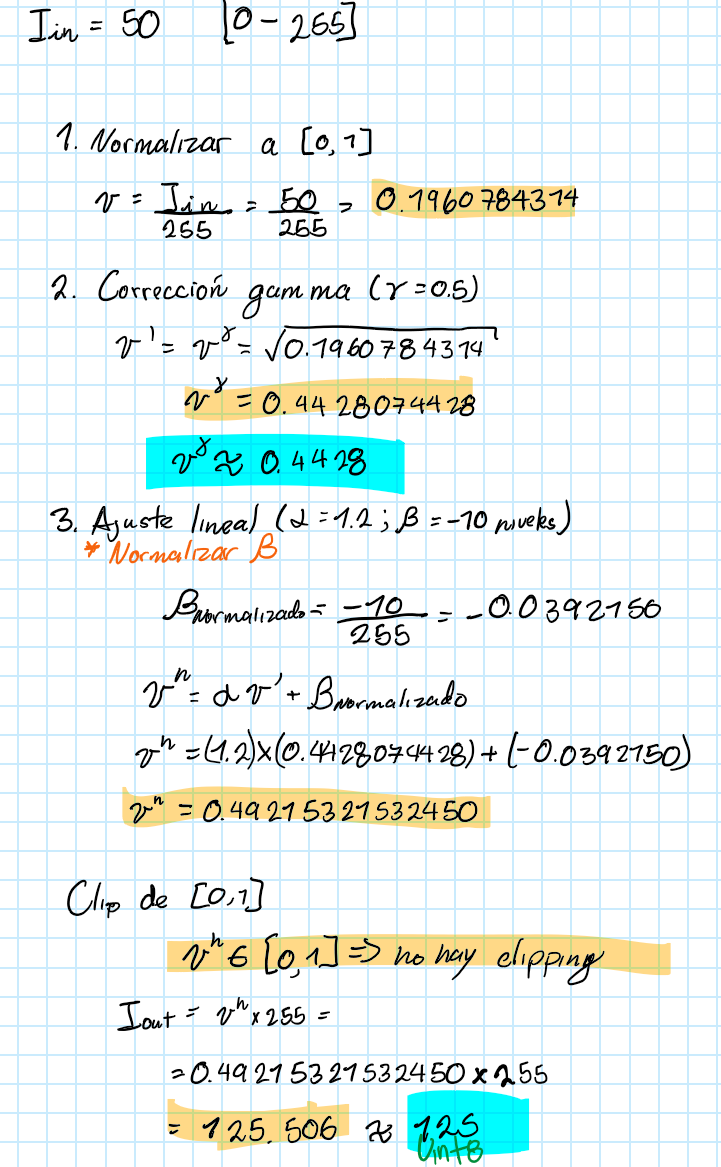

   a. Calcule el valor final del píxel I_out.  
      R//: I_out es 125 (ver imagen anterior)
 
   b. ¿Hubo saturación (clipping) en el proceso?
      R//: No hubo clipping porque 0.4921532450 ∈ [0,1].

   c. Si hubiéramos realizado las operaciones usando uint8 directamente sin convertir a float (truncando decimales en cada paso intermedio), ¿cuál habría sido el error numérico resultante?  
      R//: 
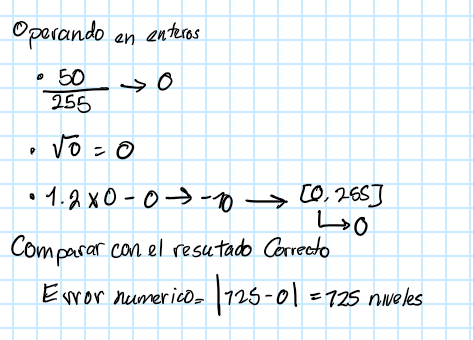

3. Usted está programando un robot clasificador de pelotas. Tiene dos objetos: una pelota roja brillante bajo el sol R_rgb=(255,0,0) y la misma pelota roja en una sombra profunda S_rgb=(50,0,0)

   a. Calcule la distancia entre estos dos colores en el espacio RGB.  
   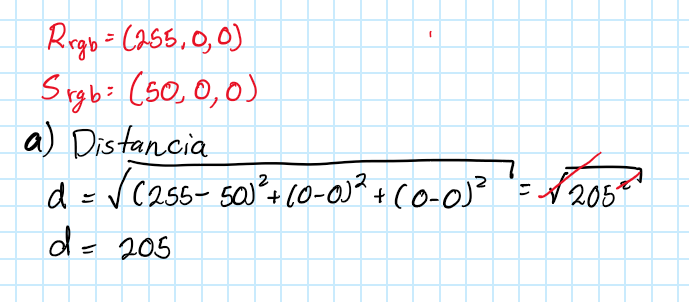

   b. Convierta ambos colores al espacio HSV (asuma rangos normalizados H∈[0,1], S∈[0,1], V∈[0,1] para simplificar, sabiendo que el Hue del rojo es 0).  
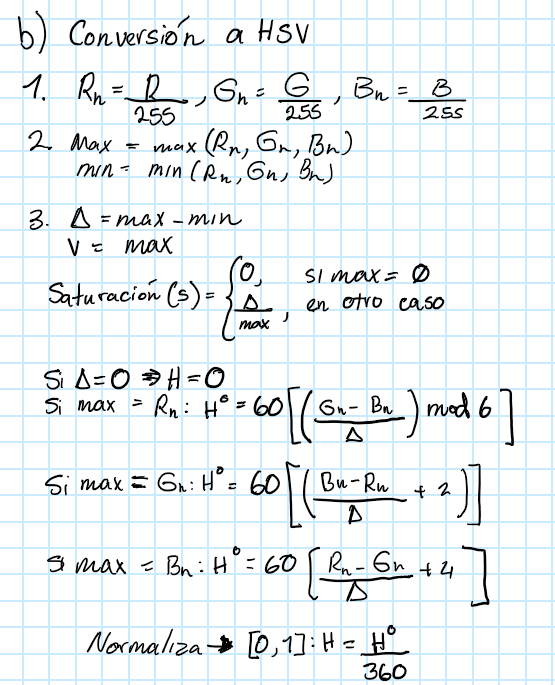
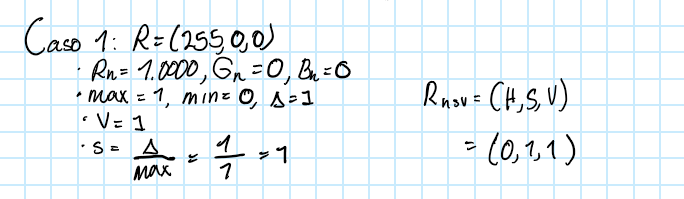
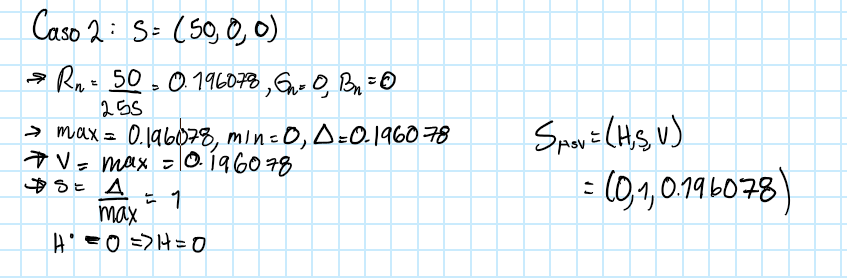
   c. Calcule la diferencia absoluta canal por canal en HSV  

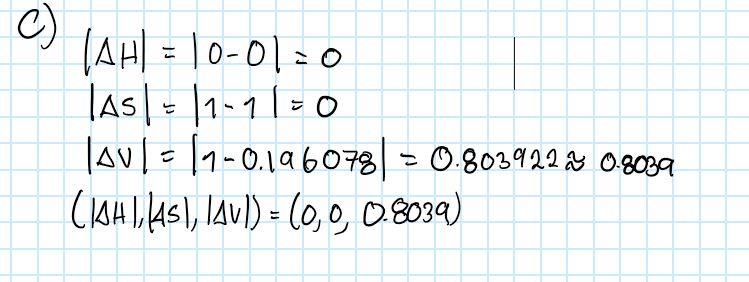

   d. Argumente matemáticamente por qué un algoritmo de agrupación (clustering) simple fallaría en RGB pero funcionaría en HSV para determinar que ambos píxeles pertenecen al mismo objeto "pelota roja". 

   R//: Modelo de luz: mismo objeto con distinta iluminación  donde 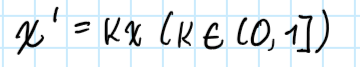. En RGB, la distancia usada por k-means es "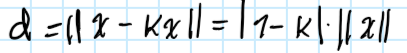" para (255,0,0) y K = 50/255, d= (0.804)(255)  dondel el algoritmo los separa.
   En HSV el pgimento conserva H(0) Y S(1), en este caso solo varia V(1 vs 0.196). Con una métrica ponderada 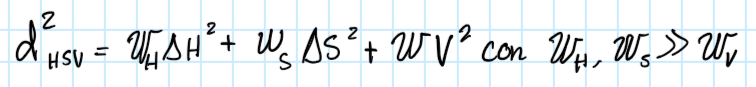, la distancia entre ambos es pequeña y el clustering los agrupa como el mismo objeto.
